In [ ]:
""" Source: Max-Cut and Traveling Salesman Problem — QiSkit Optimization 0.5.0 documentation. (s. f.). 
https://qiskit.org/ecosystem/optimization/tutorials/06_examples_max_cut_and_tsp.html

Quiskit Workshop: Solving Optimization Problems
""""

In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [3]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram

from qiskit import *
from numpy import linalg as la
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter

In [ ]:
# Extra imports

from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA

In [5]:
# Load account and select backend
IBMQ.delete_account()
IBMQ.save_account('d3d126366dc73d98c372a5c16cbedaf215d60fe92749fdca234b8e40cbe26ceb778d3579def612998e70c91f212808edd40b2ab67618f4a8dac6f2b1b96d60e4')
IBMQ.load_account()
IBMQ.stored_account()
IBMQ.load_account()


my_provider = IBMQ.get_provider(hub='ibm-q-asu', group='internal', project='reservations')
my_provider.backends()
ibmq_backend = my_provider.get_backend('ibmq_kolkata')
backend = ibmq_backend

/tmp/ipykernel_656/3170780377.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.delete_account()
ibmqfactory.load_account:WARNING:2023-09-15 16:46:38,527: Credentials are already in use. The existing account in the session will be replaced.


'Starting point: node 0\nEach point needs to visited with the smallest of distance overall.\nThe numbers the graph are the distances between each point (not to scale)\n*Every time you add the difficulty of the problem scales exponetially'

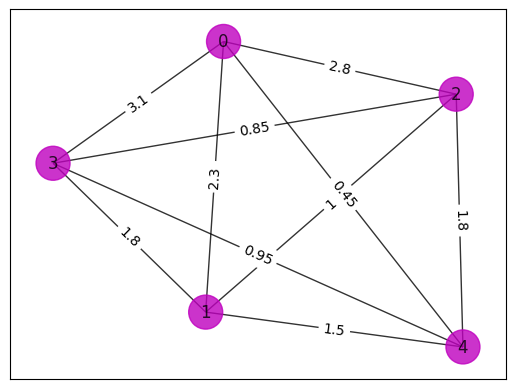

In [4]:
# Generate graph that describes the problem

n = 5  # Number of nodes in graph (number of stops)
num_qubits = n**2

G = nx.Graph() # Construct the graph with network x
G.add_nodes_from(np.arange(0, n, 1))
# Distances between the nodes
elist = [(0, 1, 2.3), (0, 2, 2.8), (0, 3, 3.1), (0, 4, 0.45), (1, 2, 1), (1,3, 1.8), (1,4, 1.5), (2,3, 0.85), (2,4, 1.8), (3,4,0.95)]

# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)


# Graph
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
colors = ["m" for node in G.nodes()]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)

"""Starting point is node 0. Each point needs to visited with the smallest of distance overall.
The numbers the graph are the distances between each point (not to scale)
*Every time you add the difficulty of the problem scales exponetially"""

In [5]:
# Computing the weight matrix from the graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

"""This matrix represents what the graph would look like just for illustrative purposes"""

[[0.   2.3  2.8  3.1  0.45]
 [2.3  0.   1.   1.8  1.5 ]
 [2.8  1.   0.   0.85 1.8 ]
 [3.1  1.8  0.85 0.   0.95]
 [0.45 1.5  1.8  0.95 0.  ]]


'This matrix represents what the graph would look like'

In [6]:
"""We turn the graph into a TSP class"""
# Tsp is the project we work with, we need to turn this into a quadratic program
hola = Tsp(G)
print(type(hola)) 

<class 'qiskit_optimization.applications.tsp.Tsp'>


In [9]:
# STEP 1: convert TSP to quadratic program
qp = hola.to_quadratic_program()
print(qp.prettyprint())

"""We get the cost equation (distance). 
The constrains control how the path has to evolve: you can go back to an already visited node
and all nodes must be visited.
We also get binary variables: five sets of five variables and each one of the sets
progresibly shows the paths that could be taken."""

Problem name: TSP

Minimize
  2.3*x_0_0*x_1_1 + 2.3*x_0_0*x_1_4 + 2.8*x_0_0*x_2_1 + 2.8*x_0_0*x_2_4
  + 3.1*x_0_0*x_3_1 + 3.1*x_0_0*x_3_4 + 0.45*x_0_0*x_4_1 + 0.45*x_0_0*x_4_4
  + 2.3*x_0_1*x_1_0 + 2.3*x_0_1*x_1_2 + 2.8*x_0_1*x_2_0 + 2.8*x_0_1*x_2_2
  + 3.1*x_0_1*x_3_0 + 3.1*x_0_1*x_3_2 + 0.45*x_0_1*x_4_0 + 0.45*x_0_1*x_4_2
  + 2.3*x_0_2*x_1_1 + 2.3*x_0_2*x_1_3 + 2.8*x_0_2*x_2_1 + 2.8*x_0_2*x_2_3
  + 3.1*x_0_2*x_3_1 + 3.1*x_0_2*x_3_3 + 0.45*x_0_2*x_4_1 + 0.45*x_0_2*x_4_3
  + 2.3*x_0_3*x_1_2 + 2.3*x_0_3*x_1_4 + 2.8*x_0_3*x_2_2 + 2.8*x_0_3*x_2_4
  + 3.1*x_0_3*x_3_2 + 3.1*x_0_3*x_3_4 + 0.45*x_0_3*x_4_2 + 0.45*x_0_3*x_4_4
  + 2.3*x_0_4*x_1_0 + 2.3*x_0_4*x_1_3 + 2.8*x_0_4*x_2_0 + 2.8*x_0_4*x_2_3
  + 3.1*x_0_4*x_3_0 + 3.1*x_0_4*x_3_3 + 0.45*x_0_4*x_4_0 + 0.45*x_0_4*x_4_3
  + x_1_0*x_2_1 + x_1_0*x_2_4 + 1.8*x_1_0*x_3_1 + 1.8*x_1_0*x_3_4
  + 1.5*x_1_0*x_4_1 + 1.5*x_1_0*x_4_4 + x_1_1*x_2_0 + x_1_1*x_2_2
  + 1.8*x_1_1*x_3_0 + 1.8*x_1_1*x_3_2 + 1.5*x_1_1*x_4_0 + 1.5*x_1_1*x_4_2
  + x_1_2*x_2_1 + 

'We get the cost equation (distance). \nThe constrains control how the path has to evolve: you can go back to an already visited node\nand all nodes must be visited.\nWe also get binary variables: five sets of five variables and each one of the sets\nprogresibly shows the paths that could be taken.'

In [11]:
# Step 2: Construct Solver

# Now we use QAOA to solve the problem
def qaoa_callback(count, params, mean, metadata):
    if count % 10 == 0:
        print('Iteration:', count, ', value:', mean)

qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=100), callback=qaoa_callback)
qaoa_meo = MinimumEigenOptimizer(qaoa)

In [ ]:
# Step 3: Compute Solution
qaoa_result = qaoa_meo.solve(qp)
#qaoa_result = optimizer.solve(qp)

print(qaoa_result)

"""fval is the minimum distance that you need to travel
The vector of variables tell you the path"""

In [ ]:
"""tsp.interpret if you give this function the solution vector of the value variables
it'll tell you what the solution path is"""

z = tsp.interpret(qaoa_result.x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, adj_matrix))


In [ ]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)
    

In [ ]:
# Graph solution path
draw_tsp_solution(tsp.graph, z, colors, pos)